**Цель этого ноутбука - получить датасет размером ~1м строк для дальнейшей работы и обучению моделей для рекомендательных систем (500к для трейна, 200к для валидации, 300к для теста).**

In [1]:
import pandas as pd

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as f

In [3]:
spark = SparkSession.builder \
        .master('local[*]') \
        .appName("Data extractor") \
        .config("spark.executor.memory", "8g") \
        .config("spark.driver.memory", "6g") \
        .getOrCreate()

In [4]:
DATA_PATH = '../../../notebooks/MADE/data.parquet'

In [5]:
spark_df = spark.read.parquet(DATA_PATH)

In [6]:
spark_df.printSchema()

root
 |-- old_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- has_doi: boolean (nullable = true)
 |-- issn: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- article_len: integer (nullable = true)
 |-- n_citation: double (nullable = true)
 |-- lang: string (nullable = true)
 |-- year: double (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- fos: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- email: string (nullable = true)
 |    |    |-- gid: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- org: string (nullable = true)
 |    |    |-- orgid: string (nullable = true)
 |    |    |-- sid: string (nullable

Выбросим элементы, содержащие мусорные значения в следующих полях:
- `abstract` - пустые значения мешают обучать модели для `Topic Modelling` (может возникнуть необходимость получить новые топики)
- `year` - это поле нужно для поиска в `Engineering`-части, пустые поля приводят к невозможности найти нужную статью
- `n_citation` - это поле также нужно для `Engineering`-части, обоснуем тем же аргументом, что и выше
- `authors` - это поле нужно будет для моделей рекомендательных систем. Чистых пустых полей здесь в любом случае немного, но удалим хотя бы явно пустые
- `title` - это лицо статьи, а класть туда `abstract` может быть не очень хорошо, т.к. по нему сходу может быть непонятно, о чём статья. Помимо мусорных значений, которые были обнаружены для `abstract`, в `title` также много названий `Foreword`, их следует убрать

In [6]:
clean_df = spark_df.na.drop(subset=['abstract', 'year', 'n_citation', 'authors', 'title'])

In [8]:
clean_df.count()

4390731

Отлично! Убранные мусорные значения уменьшили размер датасета на ~1м. 

Но все ли мусорные значения убраны? **Нет!** На самом деле в `abstract` куда больше мусорных значений, что мы выясняли на протяжении первых 2 спринтов. Уберём остальные.

In [7]:
regex_pattern = '|'.join(["no abstract", "abstract not", "without abstract", "no ref"])
clean_df = clean_df.where(
        ~(f.lower(f.trim(clean_df.abstract)).isin(['', '\xa0', '\xa0\xa0', 'N/A', 'none', 'none.'])) &
        ~(f.lower(clean_df.abstract).rlike(regex_pattern))
)

In [12]:
clean_df.count()

3549336

Казалось бы, таких значений ведь должно быть немного, но не тут-то было! Мы уменьшили датасет ещё на целых **~850к строк**!

Посмотрим теперь сколько мусорных значений мы ещё не откинули в `year`.

In [8]:
clean_df = clean_df.where(clean_df.year <= 2022)

In [14]:
clean_df.count()

3549322

Что ж, таких немного.

Выбросим ещё поля с указанным китайским языком.

In [9]:
clean_df = clean_df.where(clean_df.lang != 'zh')

In [16]:
clean_df.count()

3479592

Поля с пустым тайтлом также можно убрать - это лицо статьи, а класть туда `abstract` может быть не очень хорошо, т.к. по нему сходу может быть непонятно, о чём статья.
Помимо мусорных значений, которые были обнаружены для `abstract`, в `title` также много названий `Foreword`, их следует убрать.

In [10]:
clean_df = clean_df.where(
        ~(f.lower(f.trim(clean_df.title)).isin(['', '\xa0', '\xa0\xa0', 'N/A', 'none', 'none.', 'foreword', 'foreword.']))
)

In [12]:
clean_df.count()

3479540

Выбросим теперь поля со слишком длинными `abstract` и `title`. Предварительно проведём небольшой анализ для того, чтобы понимать, что значит "слишком длинными".

In [13]:
df = clean_df.withColumn("length", f.length("title"))

In [34]:
pd_df = df.select("length").toPandas()

In [35]:
pd_df.head()

,length
0,104
1,89
2,67
3,68
4,80


<AxesSubplot:>

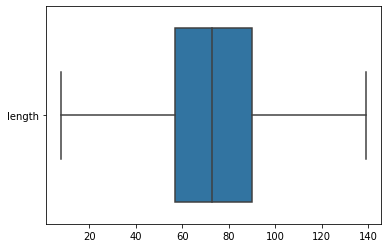

In [43]:
import seaborn as sns
sns.boxplot(pd_df, orient='h', showfliers=False)

In [46]:
pd_df[pd_df > 200].describe()

,length
count,1670.000000
mean,228.400599
std,72.983419
min,201.000000
25%,206.000000
50%,215.000000
75%,230.000000
max,1926.000000


In [47]:
df = df.withColumn("a_length", f.length('abstract'))

In [52]:
pd_df = df.select("a_length").toPandas()

In [53]:
pd_df.describe()

,a_length
count,3.479515e+06
mean,9.351087e+02
std,5.200197e+02
min,1.000000e+00
25%,6.370000e+02
50%,8.960000e+02
75%,1.169000e+03
max,1.376490e+05


<AxesSubplot:>

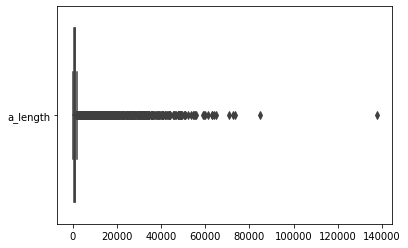

In [58]:
sns.boxplot(pd_df, orient='h', showfliers=True)

In [67]:
pd_df[pd_df > 10000].describe()

,a_length
count,331.000000
mean,27182.468278
std,15231.774959
min,10054.000000
25%,15216.500000
50%,24062.000000
75%,34271.500000
max,137649.000000


Готово! Теперь уберём поля со слишком длинными строками.

In [11]:
clean_df_ = clean_df.where((f.length(clean_df.abstract) < 10000) & (f.length(clean_df.title) < 200))

In [12]:
clean_df_.count()

3477442

Т.к. после такой уборки мы всё ещё далеки от требуемых цифр - давайте станем более привередливыми.

При проведении `EDA` были обнаружены статьи на немецком языке. Типичными для немецкого (и нетипичными для английского) языка являются умляуты и ß. Давайте удалим все абстракты с подобными буквами.

In [13]:
regex_pattern = "|".join(['ä', 'ö', 'ü', 'ß'])
clean_df_ = clean_df_.filter(
    ~f.col("abstract").rlike(regex_pattern)
)

In [23]:
clean_df_.count()

3462594

In [14]:
clean_df_ = clean_df_.na.drop(subset=['fos', 'keywords'])

In [26]:
clean_df_.count()

2699241

Можно заметить, что процент очищенных значений не совпадает с тем, что заявляется в `EDA`. Конечно, отчасти это из-за того, что `EDA` проводился не на всём датасете - приведённые числа там могут (несильно) отличаться от действительных. К тому же мы уже удалили более половины данных. Однако, даже без учёта этого в результатах нет ничего необычного - мы ещё не удалили все мусорные значения из этих полей! На самом деле что в `fos`, что в `keywords` (да и, вообще говоря, в большинстве списковых полей датасета) очень успешно хранятся списки, содержащие только мусорные (`null`) значения, которые таким простым методом не убрать.

In [15]:
clean_df_ = clean_df_.na.drop(subset=['issn', 'isbn'])

In [28]:
clean_df_.count()

2574159

Посмотрим на длину статьи (в страницах) для того, чтобы выяснить, можно ли что-то очистить по этому признаку.

In [30]:
clean_df_.select('article_len').to_pandas_on_spark().describe()

/home/ippk93/anaconda3/envs/made_1/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,article_len
count,2.228974e+06
mean,-4.640207e+02
std,7.567330e+05
min,-1.127502e+09
25%,6.000000e+00
50%,9.000000e+00
75%,1.300000e+01
max,7.166233e+07


Напомним, `article_len` = `page_end` - `page_start` (из начального датасета). Очищаем...

In [16]:
clean_df_ = clean_df_.na.drop(subset=['article_len']).where(clean_df_.article_len >= 0)

In [20]:
clean_df_.count()

2227883

Однако, ситуация всё ещё не в нашу сторону. Давайте попробуем убрать пустые списки из `keywords`.

In [17]:
def get_clean_pairs(df, col_name):
    clean_colname = col_name + '_cleaned'
    clean_df = df.withColumn(clean_colname, f.expr(f'filter({col_name}, x -> x is not null)'))
    clean_df = clean_df.na.drop(subset=[clean_colname]).where(f.col(clean_colname) != f.array())
    
    id_col = clean_df.select(f.col('old_id'), f.explode(f.col(clean_colname)))

    numbers_regex = '|'.join(map(str, range(10)))
    id_col = id_col.where(~id_col.col.rlike(numbers_regex))

    id_col = id_col.na.drop(subset=['col']).where(
        (f.length(id_col.col) < 100) & 
        ~f.lower(f.trim(id_col.col)).isin('', 'none', 'null')
    )

    id_col = id_col.groupby('old_id').agg(f.collect_set('col').alias(col_name))
    
    return id_col

In [18]:
id_kws = get_clean_pairs(clean_df_, 'keywords')

In [20]:
id_kws.count()

2216306

In [82]:
id_kws.show()

+--------------------+--------------------+
|              old_id|            keywords|
+--------------------+--------------------+
|53e99796b7602d970...|[Dynamic scheduli...|
|53e99796b7602d970...|[diagnostic test,...|
|53e997cbb7602d970...|[semi-supervised ...|
|53e997cbb7602d970...|[direct volume re...|
|53e997cbb7602d970...|[human-computer s...|
|53e997cbb7602d970...|[thk analysis, pr...|
|53e997cbb7602d970...|[natural deductio...|
|53e997ccb7602d970...|[Snapshots, Combi...|
|53e997ccb7602d970...|[software perform...|
|53e997ccb7602d970...|[Reachability and...|
|53e997ccb7602d970...|[Cellular frustra...|
|53e997ccb7602d970...|[MIMO, SpaceÂ¿tim...|
|53e997ccb7602d970...|[protein sequence...|
|53e997ccb7602d970...|[additional opini...|
|53e997ccb7602d970...|[Convex Domain, C...|
|53e997ccb7602d970...|[fuzzy logic, ext...|
|53e997ccb7602d970...|[Minimal spanning...|
|53e997ccb7602d970...|[opportunistic sp...|
|53e997ccb7602d970...|[software perform...|
|53e997ccb7602d970...|[data type

In [19]:
def join_tables(df, df_other, col_name):
    df_ = df.drop(col_name)
    
    df_ = df_.alias('df')
    df_other_ = df_other.alias('df_other')
    
    df_ = df_.join(df_other_, df_.old_id == df_other_.old_id).select('df.*', f'df_other.{col_name}')
    
    return df_

In [20]:
clean_df_ = join_tables(clean_df_, id_kws, 'keywords')

In [23]:
clean_df_.count()

2216306

In [21]:
id_fos = get_clean_pairs(clean_df_, 'fos')

In [22]:
clean_df_ = join_tables(clean_df_, id_fos, 'fos')

In [23]:
clean_df_.count()

2216306

In [27]:
kw_lengths = id_kws.select(f.explode('keywords'))
kw_lengths = kw_lengths.select(f.length('col').alias('kw_len'))

In [28]:
kw_lengths.select('kw_len').to_pandas_on_spark().describe()

/home/ippk93/anaconda3/envs/made_1/lib/python3.10/site-packages/pyspark/sql/dataframe.py:3313: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,kw_len
count,2.433472e+07
mean,1.873100e+01
std,8.006507e+00
min,1.000000e+00
25%,1.400000e+01
50%,1.800000e+01
75%,2.300000e+01
max,9.900000e+01


На текущем уровне датасет очищен достаточно. Дальнейшую очистку будем проводить по `references` и `authors`, как и требуется в оставшихся задачах. Это будет сделано уже в следующем ноутбуке.

In [29]:
clean_df_.write.parquet('ref_authors_process.parquet')